From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



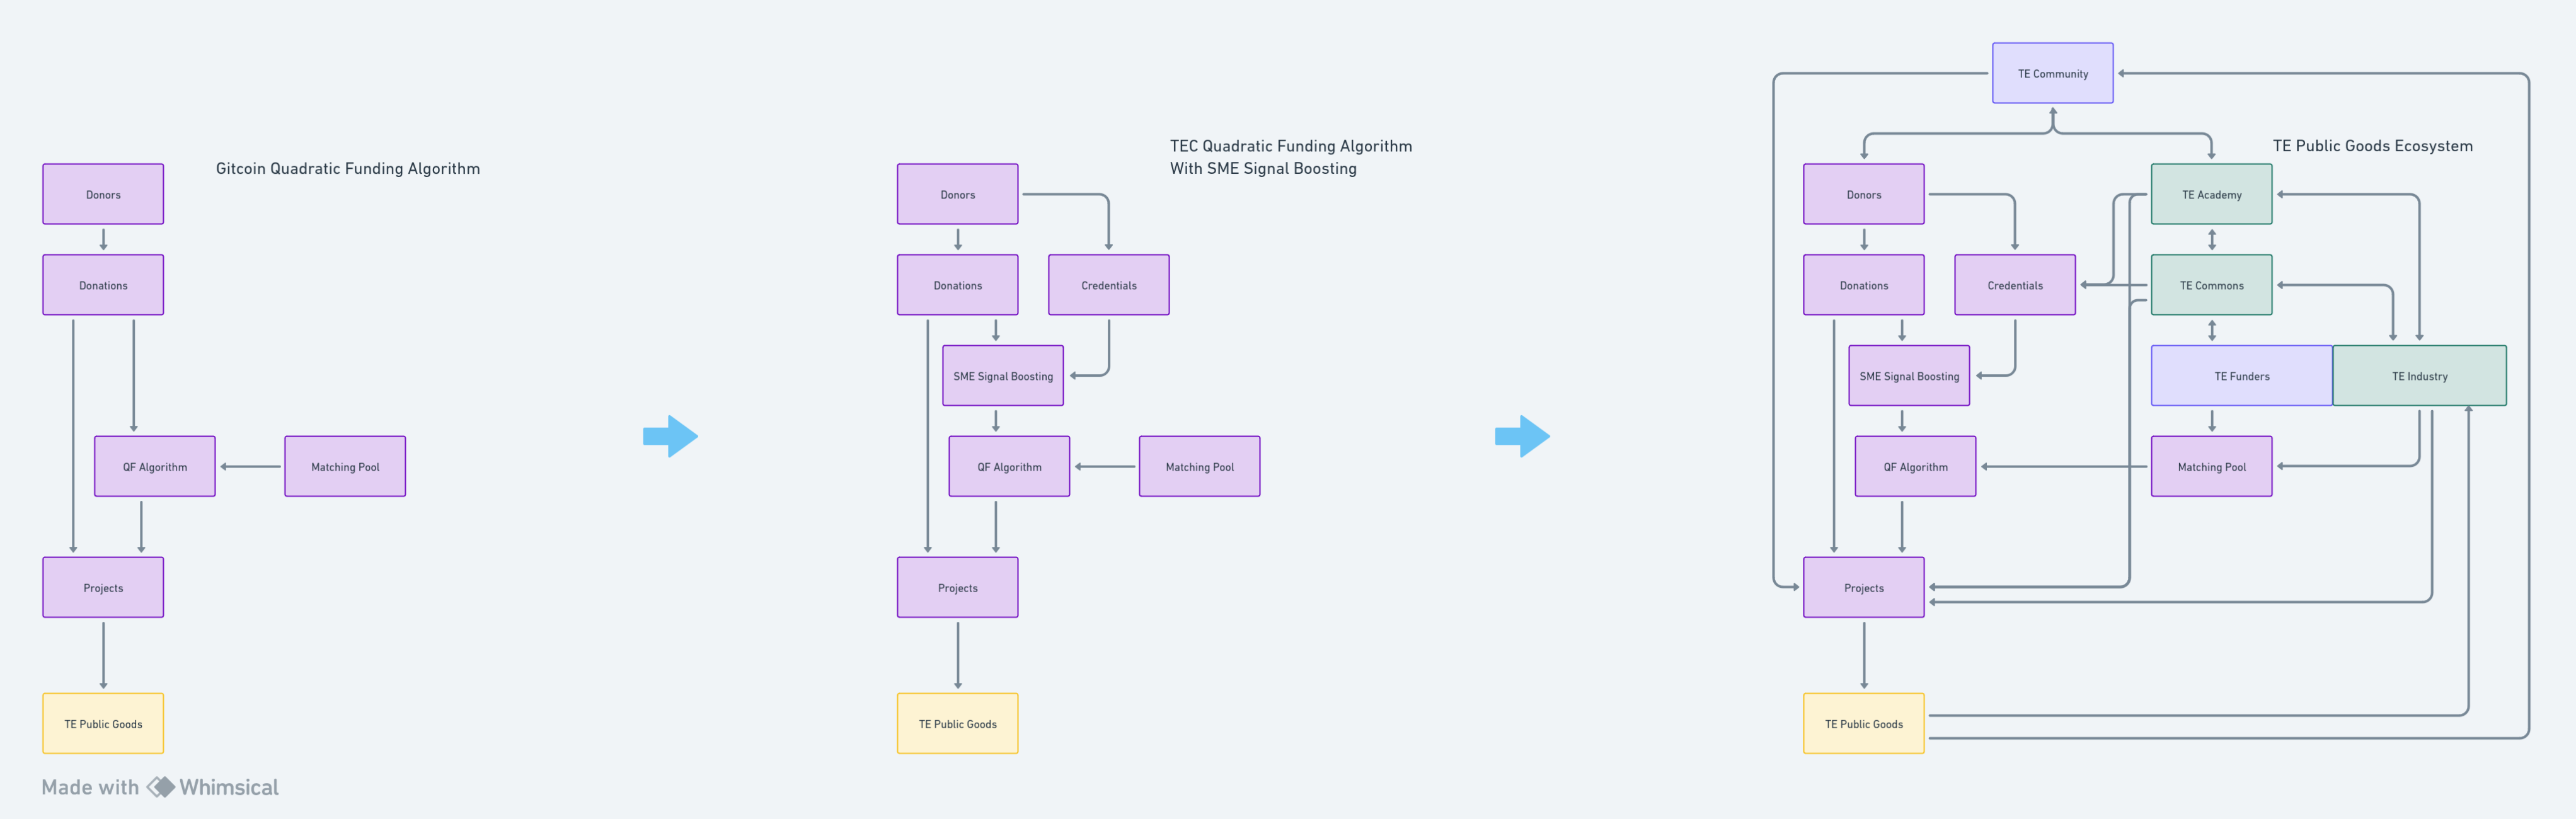![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

## A Flexible Design for Funding Public Goods

https://arxiv.org/pdf/1809.06421.pdf

### 3.0 Model

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 30

# Society is a set of citizens
society = set(range(N))

# Community is a random subset of the society. The community size is from 1 up to 1/2 of the society.
community = np.random.choice(a=list(society), size=np.random.randint(1, len(society)/2), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 1 up to 1/2 size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(1, len(community)/2), replace=True, p=None)))

In [2]:
community

array([23,  8, 14, 17,  2, 25, 18, 21, 16,  5, 28,  0])

In [3]:
public_goods

[(0, 23)]

In [4]:
len(society)

30

In [5]:
len(community)

12

In [6]:
len(public_goods)

1

### 3.1 Individual Preferences and Actions

The paper calls for Concave, Smooth, Increasing preferences towards the funding of public goods.

The concave value generator has the following properties:
1. f0 = f(0) is in [0,1]
2. f1 = f(1) is in [f0,1]
3. f(x) = 1 - e**(-s*x)
4. The negative exponential function provides a smooth, concave, increasing function from f0 to f1 with a parameterized steepness.

In [7]:
import param
import numpy as np
import panel as pn
import hvplot.pandas
import pandas as pd

class ConcaveFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), softbounds=(0, 1), doc="Value of f(1)")
    steepness = param.Number(default=5, bounds=(1, 20), doc="Steepness of the curve")

    def __init__(self, **params):
        super().__init__(**params)
        self._update_f1_bounds()

    @param.depends('f0', watch=True)
    def _update_f1_bounds(self):
        # Clip the value of f1 if it's below f0
        self.f1 = max(self.f0, self.f1)
        
        # Update the lower bound of f1 to be the value of f0
        self.param['f1'].bounds = (self.f0, 1)
        
    def x(self):
        return np.linspace(0, 1, 400)

    @param.depends('f0', 'f1', 'steepness')
    def f(self, x):
        # Using the negative exponential function as a base
        y = 1 - np.exp(-self.steepness * x)
        
        # Adjusting the function to start at f0 and end at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        
        return y

    @param.depends('f0', 'f1', 'steepness')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

concave_gen = ConcaveFunctionGenerator()
pn.Row(concave_gen.param, concave_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='ConcaveFunctionGenerator'...)
        [0] StaticText(value='<b>ConcaveFunctionGenerat...)
        [1] FloatSlider(name='F0', value=0.2)
        [2] FloatSlider(name='F1', start=0.2, value=0.8)
        [3] FloatSlider(end=20, name='Steepness', start=1, value=5)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

The class dynamically clips f1 to satisfy property 2. Such as in the following example:

In [8]:
ConcaveFunctionGenerator(f0=1,f1=0)

ConcaveFunctionGenerator(f0=1, f1=1, name='ConcaveFunctionGenerator00955', steepness=5)

Here we propose parameter generators for sampling concave functions

In [9]:
import numbergen as ng
import numpy as np


# For CurveGenerator
def concave_function_parameters_generator():
    return dict(
        f0=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.1, sigma=0.3), bounds=(0,1))(),
        f1=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.5, sigma=0.4), bounds=(0,1))(),
        steepness=ng.UniformRandom(lbound=1, ubound=20)(),
    )

This method generates random parameters given the distributions described for f0, f1, and steepness above. 
* f0 is a normal distribution at (0.1,0.3), clipped at (0,1)
* f0 is a normal distribution at (0.5,0.4), clipped at (0,1)
* steepness is a uniform distribution at (1,20)

In [11]:
concave_function_parameters_generator()

{'f0': 0.41203799420832765,
 'f1': 0.7494773203995513,
 'steepness': 17.59370001416582}

In [12]:
value_functions = [ConcaveFunctionGenerator(**concave_function_parameters_generator()) for p_i in range(len(public_goods)*len(society))]

Here we can see all of the preferences of the citizens. These are the value functions V_p_i(F_p). There is one preference function for each V_p_i in {public_goods}X{citizens}. Cardinality is len(public_goods)*len(citizens).

In [13]:
import pandas as pd

pd.DataFrame([s.param.values() for s in value_functions])

sample_p_i_slider = pn.widgets.IntSlider(name='Utility Value Function', start=0, end=len(value_functions)-1)

pn.Row(sample_p_i_slider, pn.bind(lambda i: value_functions[i].view(), i=sample_p_i_slider))

Row
    [0] IntSlider(end=29, name='Utility Value Function')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

Create a Dataframe! These are citizen preferences by funding amounts for public goods. Take Funding Amount as the Index by applying a transpose. 

In [14]:
df_value_functions = pd.DataFrame([s.f(s.x()) for s in value_functions])
df_value_functions = df_value_functions.T
df_value_functions.shape

(400, 30)

Make Funding the Index from 0 to 100

In [15]:
df_value_functions.index = np.linspace(0,1,len(df_value_functions))
df_value_functions.index.name = "funding"

Label the Columns by {public_goods}X{Citizens}.

In [16]:
df_value_functions.columns = [(p, i) for p in public_goods for i in society]
df_value_functions.columns.name = "value_p_i"


Number of columns is len(public_goods)*len(society).

In [17]:
df_value_functions

value_p_i,"((0, 23), 0)","((0, 23), 1)","((0, 23), 2)","((0, 23), 3)","((0, 23), 4)","((0, 23), 5)","((0, 23), 6)","((0, 23), 7)","((0, 23), 8)","((0, 23), 9)",...,"((0, 23), 20)","((0, 23), 21)","((0, 23), 22)","((0, 23), 23)","((0, 23), 24)","((0, 23), 25)","((0, 23), 26)","((0, 23), 27)","((0, 23), 28)","((0, 23), 29)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.118641,0.216779,0.020148,0.27334,0.000000,0.000000,0.326520,0.000000,0.184131,0.201203,...,0.0,0.000000,0.444764,0.358694,0.006028,0.035247,0.496952,0.20339,0.378514,0.324910
0.002506,0.118641,0.221254,0.022037,0.27334,0.001612,0.008418,0.331910,0.013546,0.186378,0.206448,...,0.0,0.007605,0.444764,0.362355,0.008935,0.037370,0.496952,0.20339,0.378514,0.333268
0.005013,0.118641,0.225694,0.023914,0.27334,0.003156,0.016433,0.337206,0.026662,0.188611,0.211661,...,0.0,0.015061,0.444764,0.365844,0.011826,0.039486,0.496952,0.20339,0.378514,0.341323
0.007519,0.118641,0.230100,0.025778,0.27334,0.004635,0.024063,0.342409,0.039361,0.190830,0.216843,...,0.0,0.022371,0.444764,0.369168,0.014703,0.041597,0.496952,0.20339,0.378514,0.349086
0.010025,0.118641,0.234471,0.027630,0.27334,0.006050,0.031328,0.347520,0.051657,0.193035,0.221994,...,0.0,0.029538,0.444764,0.372336,0.017565,0.043702,0.496952,0.20339,0.378514,0.356567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.118641,0.764624,0.285048,0.27334,0.037990,0.175583,0.632499,0.426366,0.507987,0.991007,...,0.0,0.388867,0.444764,0.436396,0.498749,0.552511,0.496952,0.20339,0.378514,0.555291
0.992481,0.118641,0.764827,0.285185,0.27334,0.037990,0.175583,0.632504,0.426366,0.508166,0.991488,...,0.0,0.388871,0.444764,0.436396,0.499131,0.553245,0.496952,0.20339,0.378514,0.555291
0.994987,0.118641,0.765029,0.285322,0.27334,0.037990,0.175583,0.632509,0.426366,0.508343,0.991966,...,0.0,0.388874,0.444764,0.436396,0.499511,0.553977,0.496952,0.20339,0.378514,0.555291


Display Citizen Preferences for Funding.

In [18]:
df_value_functions.hvplot.line(x='funding', color='blue', alpha=0.1, line_width=3, ylabel='Value to Citizens', title='Smooth, Concave, Increasing Value Functions')

:NdOverlay   [value_p_i]
   :Curve   [funding]   (value)

Mean preferences for funding public goods.

In [19]:
df_value_functions['mean'] = df_value_functions.mean(axis=1)
df_value_functions['std'] = df_value_functions.std(axis=1)
df_value_functions['low'] = df_value_functions['mean'] - df_value_functions['std']
df_value_functions['high'] = df_value_functions['mean'] + df_value_functions['std']

df_value_functions.hvplot.line(y='mean', ylabel='Value to Society') * df_value_functions.hvplot.area(y='low',y2='high', alpha=0.5, title='Mean Value to Society Given Funding')

:Overlay
   .Curve.I :Curve   [funding]   (mean)
   .Area.I  :Area   [funding]   (low,high)

Moving on..

In [20]:
df_value_functions.drop(['mean','std','low','high'],axis=1,inplace=True)

Melting preferences to get groupby on public good or on citizen.

In [21]:
df_value_functions_melted = df_value_functions.melt(ignore_index=False)
df_value_functions_melted['public_good'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
df_value_functions_melted['citizen'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 23), 0)",0.118641,"(0, 23)",0
0.002506,"((0, 23), 0)",0.118641,"(0, 23)",0
0.005013,"((0, 23), 0)",0.118641,"(0, 23)",0
0.007519,"((0, 23), 0)",0.118641,"(0, 23)",0
0.010025,"((0, 23), 0)",0.118641,"(0, 23)",0
...,...,...,...,...
0.989975,"((0, 23), 29)",0.555291,"(0, 23)",29
0.992481,"((0, 23), 29)",0.555291,"(0, 23)",29
0.994987,"((0, 23), 29)",0.555291,"(0, 23)",29


Groupby funding and public good to get mean funding preferences per public good.

In [22]:
mean_utility_df = df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index()

Display mean value function per public good.

In [23]:
mean_utility_df.hvplot.line(y='value', by='public_good', alpha=0.8, line_width=4, x='funding', title='Mean Value to Society per Public Good Given Funding')

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

Display mean value function per citizen.

In [24]:
mean_utility_df2 = df_value_functions_melted.groupby(['funding', 'citizen'])[['value']].mean().reset_index()

In [25]:
mean_utility_df2.hvplot.line(y='value', by='citizen', alpha=0.8, line_width=4, x='funding', title='Mean Public Good Preference Value Function per Citizen')

:NdOverlay   [citizen]
   :Curve   [funding]   (value)